In [1]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import os, copy, random
import matplotlib.pyplot as plt
import collections
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics

#Reference : https://github.com/zalandoresearch/fashion-mnist utils/mnist_reader.
def load_mnist(path, kind='train'):
    import os
    import gzip
    import numpy as np

    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

Sandal


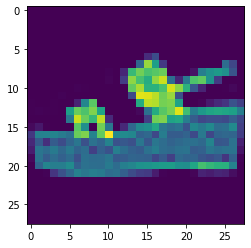

In [2]:
classes=('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
X_train, y_train = load_mnist('./dataset/fashion_mnist/', kind='train')
X_test, y_test = load_mnist('./dataset/fashion_mnist/', kind='t10k')
# visualize and check data and label.
index = 12
plt.imshow(X_train[index].reshape(28,28))
print(classes[y_train[index]])

In [3]:
# count number of each class -> check data balance.
train_count = collections.Counter(y_train)
print(train_count)
test_count = collections.Counter(y_test)
print(test_count)

Counter({9: 6000, 0: 6000, 3: 6000, 2: 6000, 7: 6000, 5: 6000, 1: 6000, 6: 6000, 4: 6000, 8: 6000})
Counter({9: 1000, 2: 1000, 1: 1000, 6: 1000, 4: 1000, 5: 1000, 7: 1000, 3: 1000, 8: 1000, 0: 1000})


In [4]:
#make this reproducible with seed fixed
np.random.seed(42)

#subsampling each class
subset_X_train = []
subset_y_train = []
subset_per_each_train = 600
for i in range(len(classes)):
    _class_idx = np.where(y_train == i)[0]
    print('sampled from class {} : {}'.format(i, len(_class_idx)))
    np.random.shuffle(_class_idx)
    subset_X_train.extend(X_train[_class_idx[:subset_per_each_train]])
    subset_y_train.extend(y_train[_class_idx[:subset_per_each_train]])

subset_X_test = []
subset_y_test = []
subset_per_each_test = 100
for i in range(len(classes)):
    _class_idx = np.where(y_test == i)[0]
    print('sampled from class {} : {}'.format(i, len(_class_idx)))
    np.random.shuffle(_class_idx)
    subset_X_test.extend(X_train[_class_idx[:subset_per_each_test]])
    subset_y_test.extend(y_train[_class_idx[:subset_per_each_test]])

print(len(subset_X_train), len(subset_y_train))
print(len(subset_X_test), len(subset_y_test))

scaler = StandardScaler()
subset_X_train = scaler.fit_transform(np.array(subset_X_train))
subset_y_train = np.array(subset_y_train)
subset_X_test = scaler.fit_transform(np.array(subset_X_test))
subset_y_test = np.array(subset_y_test)


sampled from class 0 : 6000
sampled from class 1 : 6000
sampled from class 2 : 6000
sampled from class 3 : 6000
sampled from class 4 : 6000
sampled from class 5 : 6000
sampled from class 6 : 6000
sampled from class 7 : 6000
sampled from class 8 : 6000
sampled from class 9 : 6000
sampled from class 0 : 1000
sampled from class 1 : 1000
sampled from class 2 : 1000
sampled from class 3 : 1000
sampled from class 4 : 1000
sampled from class 5 : 1000
sampled from class 6 : 1000
sampled from class 7 : 1000
sampled from class 8 : 1000
sampled from class 9 : 1000
6000 6000
1000 1000


In [5]:
parameters = {'kernel':["linear", "poly", "rbf"]}
clf = SVC()
clf_GS = GridSearchCV(clf, parameters, verbose=2, cv=10, n_jobs=-1)
clf_GS.fit(subset_X_train, subset_y_train)


Fitting 10 folds for each of 3 candidates, totalling 30 fits


GridSearchCV(cv=10, estimator=SVC(), n_jobs=-1,
             param_grid={'kernel': ['linear', 'poly', 'rbf']}, verbose=2)

In [6]:
print(clf_GS.best_params_)
print(clf_GS.cv_results_)

{'kernel': 'rbf'}
{'mean_fit_time': array([12.15431337, 33.90897512, 36.16587639]), 'std_fit_time': array([2.8534137 , 9.85000777, 5.44280849]), 'mean_score_time': array([ 1.87587302,  5.19904382, 10.11434309]), 'std_score_time': array([0.10331823, 1.30116777, 2.02593477]), 'param_kernel': masked_array(data=['linear', 'poly', 'rbf'],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'kernel': 'linear'}, {'kernel': 'poly'}, {'kernel': 'rbf'}], 'split0_test_score': array([0.78833333, 0.8       , 0.83666667]), 'split1_test_score': array([0.80333333, 0.78833333, 0.82833333]), 'split2_test_score': array([0.76666667, 0.81166667, 0.83166667]), 'split3_test_score': array([0.80166667, 0.80166667, 0.84333333]), 'split4_test_score': array([0.81166667, 0.79166667, 0.835     ]), 'split5_test_score': array([0.79333333, 0.81833333, 0.84      ]), 'split6_test_score': array([0.805     , 0.81      , 0.85166667]), 'split7_test_score': array([0.80666667

In [7]:
subset_y_test_pred = clf_GS.best_estimator_.predict(subset_X_test)
test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
print('Test Accuracy of best model: {}'.format(test_acc))

Test Accuracy of best model: 0.87


In [8]:
#for learning rate analysis change subset_per_each_train as 100, 200, 300, 400, 500, 600

#make this reproducible with seed fixed
np.random.seed(42)

#subsampling each class
subset_X_train = []
subset_y_train = []
subset_per_each_train = 600
for i in range(len(classes)):
    _class_idx = np.where(y_train == i)[0]
    print('sampled from class {} : {}'.format(i, len(_class_idx)))
    np.random.shuffle(_class_idx)
    subset_X_train.extend(X_train[_class_idx[:subset_per_each_train]])
    subset_y_train.extend(y_train[_class_idx[:subset_per_each_train]])

print(len(subset_X_train), len(subset_y_train))
print(len(subset_X_test), len(subset_y_test))

scaler = StandardScaler()
subset_X_train = scaler.fit_transform(np.array(subset_X_train))
subset_y_train = np.array(subset_y_train)

sampled from class 0 : 6000
sampled from class 1 : 6000
sampled from class 2 : 6000
sampled from class 3 : 6000
sampled from class 4 : 6000
sampled from class 5 : 6000
sampled from class 6 : 6000
sampled from class 7 : 6000
sampled from class 8 : 6000
sampled from class 9 : 6000
6000 6000
1000 1000


In [9]:
l_clf = SVC(kernel="poly")
l_clf.fit(subset_X_train, subset_y_train)
subset_y_test_pred = l_clf.predict(subset_X_test)
train_score = l_clf.score(subset_X_train, subset_y_train)
test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
print('Train score {:.4f} Test Accuracy of best model: {}'.format(train_score, test_acc))

Train score 0.8840 Test Accuracy of best model: 0.83


In [10]:
#performance
import time
t1 = time.time()
l_clf = SVC(kernel="poly")
l_clf.fit(subset_X_train, subset_y_train)
end_t1 = time.time()
train_score = l_clf.score(subset_X_train, subset_y_train)
t2 = time.time()
subset_y_test_pred = l_clf.predict(subset_X_test)
#test_acc = metrics.accuracy_score(subset_y_test, subset_y_test_pred)
end_t2 = time.time()
print('Train time {:.4f} Test time {:.4f}'.format((end_t1 - t1), (end_t2 - t2)))

Train time 44.0440 Test time 7.9486
